<a href="https://colab.research.google.com/github/Mittra19/Image_Restoration/blob/main/Image_Restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import view_as_windows as viewW
from sklearn import preprocessing
from sklearn.linear_model import OrthogonalMatchingPursuit as omp
from scipy import sparse as sps
import scipy

In [ ]:
image = plt.imread("/content/drive/MyDrive/Colab Notebooks/kSVD/img01.png")
print(len(image.shape))

3


In [ ]:
image2 = plt.imread("/content/drive/MyDrive/Colab Notebooks/kSVD/barbara.png")
image2.shape

(512, 512)

In [ ]:
# Forming new image
bb = 8
overlap = 3
NN = int(np.ceil((image.shape[0]-bb)/overlap))*overlap+bb
MM = int(np.ceil((image.shape[1]-bb)/overlap))*overlap+bb
img_new = np.zeros((NN, MM, dims))
img_new[:h, :w, :] = image[:, :, :]
if dims == 3:
  print(img_new.shape)
  plt.imshow(img_new)
else:
  print(img_new.shape)
  plt.imshow(np.reshape(img_new, (img_new.shape[0], img_new.shape[1])), cmap = 'gray')

NameError: ignored

In [ ]:
plt.imshow(img_new)

In [ ]:
plt.imshow((image[:, :, 0] == 0), cmap = 'gray')

In [ ]:
row = int((image.shape[0]-bb)/overlap)
col = int((image.shape[1]-bb)/overlap)
dims = image.shape[2]
patches = []
for i in range(row):
  for j in range(col):
    patches.append(np.reshape(image[0+i*overlap:bb+i*overlap, 0+j*overlap:bb+j*overlap], (bb*bb*dims, 1)))

In [ ]:
patches = np.array(patches)
patches = patches.reshape(patches.shape[0], patches.shape[1])
patches.shape

In [ ]:
row = int((image.shape[0]-bb)/overlap)
col = int((image.shape[1]-bb)/overlap)
dims = image.shape[2]
I = np.zeros((image.shape[0], image.shape[1], dims))
counter = 0
for i in range(row):
  for j in range(col):
    I[0+i*overlap:bb+i*overlap, 0+j*overlap:bb+j*overlap] = np.reshape(patches[counter, :], (bb, bb, dims))
    counter = counter + 1

plt.imshow(I)

In [185]:
def OMP_Inpainting(D, X, Mask, sigma, rc_min, n_nonzero_coeff):
  """
  Orthogonal Matching pursuit
  ---------------------------
  Inputs:
    D - Dictionary
    X - The signals to represent
    errorGoal - Maximum allowed representation error

  Output:
    A - Sparse Coefficient Matrix

  """
  n, P = X.shape
  n, K = D.shape
  temp = np.zeros((K, P))
  for i in range(P):
    Mpos = np.argwhere(Mask[:, i]!=0)
    print("Mpos shape:"+str(Mpos.shape))
    Mpos = Mpos.reshape(1, Mpos.shape[0])[0]
    print("Mpos:"+str(Mpos))
    Dict = D[Mpos, :]
    print(Dict.shape)
    print(np.dot(Dict.T, Dict))
    print(np.diag(np.dot(Dict.T, Dict)))
    div = np.sqrt(np.diag(np.dot(Dict.T, Dict)))
    div[np.argwhere(div == 0)] = 0.000000001
    print(div)
    #div = np.nan_to_num(div)
    W=1.0/div;
    print("W: "+str(W))
    Dict=np.dot(Dict, np.diag(W));
    x=X[Mpos,i] # patch exclude mask
    print(x)
    x = x.reshape(x.shape[0], -1)
    a = []
    DD = []
    residual=x
    indx = []
    j = 0
    rc_max = 99999
    threshold = np.linalg.norm(x)*sigma
    print(len(a))
    while np.linalg.norm(residual)>threshold and rc_max>rc_min and len(a)<n_nonzero_coeff:
      
      proj= np.matmul(Dict.T,residual)
      pos = np.argmax(np.abs(proj), axis=0)
      indx.append(pos)
      if j==0:
        DD.append(Dict[:, pos])
        DDD = np.array(DD)
        DDD = DDD.reshape(DDD.shape[0]*DDD.shape[1], DDD.shape[2])
      else:
        DDD = np.concatenate((DDD, Dict[:, pos]), axis=1)
      #print("DDD shape: "+str(DDD.shape))
      
      print("DDD shape: "+str(DDD.shape))
      print("x shape: and type: "+str(x.shape)+", "+str(type(x)))
      a = np.matmul(scipy.linalg.pinv2(DDD),x)
      print("a shape: and type: "+str(a.shape)+", "+str(type(a)))
      residual = x - np.matmul(DDD,a)
      j = j+1
    temp[indx, i] = a
    temp[:, i] = np.multiply(W, temp[:, i])
    #A = sps.csr_matrix(temp)
  return temp

In [186]:
def OMP(D, X, L):
  """
  Orthogonal Matching pursuit
  ---------------------------
  Inputs:
    D - Dictionary
    X - The signals to represent
    errorGoal - Maximum allowed representation error

  Output:
    A - Sparse Coefficient Matrix

  """
  n, P = X.shape
  n, K = D.shape
  temp = np.zeros((K, P))
  for i in range(P):
    a = []
    x=X[:, i]
    residual=x
    indx = []
    for j in range(L):
      proj= np.matmul(D.T,residual)
      pos = np.argmax(np.abs(proj), axis=0)
      indx.append(pos)
      a = np.matmul(scipy.linalg.pinv2(D[:, indx]),x)
      residual = x - np.matmul(D[: , indx],a)
      if np.sum(np.power(residual, 2)) <1e-6:
        break
    temp[indx, i] = a
    #A = sps.csr_matrix(temp)
  return temp

In [187]:
phi = np.array(
    [
     [1, 0, 1, 0, 0, 1],
     [0, 1, 1, 1, 0, 0],
     [1, 0, 0, 1, 1, 0],
     [0, 1, 0, 0, 1, 1]
    ]
, dtype='float64')

y = np.array(
    [
     [1, 2],
     [2, 5],
     [3, 6],
     [5, 8]
    ]
)

msk = np.array(
    [
     [0, 0],
     [0, 1],
     [1, 1],
     [1, 0]
    ]
)
print("Data(y) shape: "+str(y.shape))
print("phi shape: "+str(phi.shape))

Data(y) shape: (4, 2)
phi shape: (4, 6)


In [188]:
A = OMP_Inpainting(D=phi, X=y, Mask=msk, sigma=0.01, rc_min=0.01, n_nonzero_coeff=2)

Mpos shape:(2, 1)
Mpos:[2 3]
(2, 6)
[[1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 2. 1.]
 [0. 1. 0. 0. 1. 1.]]
[1. 1. 0. 1. 2. 1.]
[1.00000000e+00 1.00000000e+00 1.00000000e-09 1.00000000e+00
 1.41421356e+00 1.00000000e+00]
W: [1.00000000e+00 1.00000000e+00 1.00000000e+09 1.00000000e+00
 7.07106781e-01 1.00000000e+00]
[3 5]
0
DDD shape: (2, 1)
x shape: and type: (2, 1), <class 'numpy.ndarray'>
a shape: and type: (1, 1), <class 'numpy.ndarray'>
DDD shape: (2, 2)
x shape: and type: (2, 1), <class 'numpy.ndarray'>
a shape: and type: (2, 1), <class 'numpy.ndarray'>
Mpos shape:(2, 1)
Mpos:[1 2]
(2, 6)
[[1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 2. 1. 0.]
 [1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]
[1. 1. 1. 2. 1. 0.]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.41421356e+00
 1.00000000e+00 1.00000000e-09]
W: [1.00000000e+00 1.00000000e+00 1.00000000e+00 7.07106781e-01
 1.00000000e+00 1.00000000e+09]
[5 6]
0


In [189]:
A

array([[0., 1.],
       [2., 0.],
       [0., 0.],
       [0., 5.],
       [3., 0.],
       [0., 0.]])

In [128]:
B = OMP(phi, y, 2)
B

array([[0. , 0. ],
       [2. , 0. ],
       [0. , 3.5],
       [0. , 0. ],
       [3. , 7. ],
       [0. , 0. ]])

#Main Functions

In [5]:
def image_read(image_path):
  image = plt.imread(image_path)
  if len(image.shape) == 3:
    print("Image shape: "+str(image.shape))
    plt.imshow(image)
  else:
    plt.imshow(image, cmap='gray')
    image = image.reshape(image.shape[0], image.shape[1], 1)
    print("Image shape: "+str(image.shape))
  return image, image.shape[0], image.shape[1], image.shape[2]

In [6]:
def form_compatible_image(bb, overlap, image):
  NN = int(np.ceil((image.shape[0]-bb)/overlap))*overlap+bb
  MM = int(np.ceil((image.shape[1]-bb)/overlap))*overlap+bb
  img_new = np.zeros((NN, MM, dims))
  img_new[:h, :w, :] = image[:, :, :]
  if dims == 3:
    print(img_new.shape)
    plt.imshow(img_new)
  else:
    print(img_new.shape)
    plt.imshow(np.reshape(img_new, (img_new.shape[0], img_new.shape[1])), cmap = 'gray')
  return img_new

In [7]:
def get_mask(image):
  mask = (image[:, :, 0] == 0)
  plt.imshow(mask, cmap='gray')
  return mask

In [8]:
def extract_image_patches(image, bb, overlap):
  row = int((image.shape[0]-bb)/overlap)
  col = int((image.shape[1]-bb)/overlap)
  dims = image.shape[2]
  patches = []
  for i in range(row):
    for j in range(col):
      patches.append(np.reshape(image[0+i*overlap:bb+i*overlap, 0+j*overlap:bb+j*overlap], (bb*bb*dims, 1)))

  patches = np.array(patches)
  patches = patches.reshape(patches.shape[0], patches.shape[1])
  return patches

In [9]:
#edit needed
def extract_image_from_patches(patches, bb, overlap, image):
  row = int((image.shape[0]-bb)/overlap)
  col = int((image.shape[1]-bb)/overlap)
  dims = image.shape[2]
  I = np.zeros((image.shape[0], image.shape[1], dims))
  counter = 0
  for i in range(row):
    for j in range(col):
      I[0+i*overlap:bb+i*overlap, 0+j*overlap:bb+j*overlap] = np.reshape(patches[counter, :], (bb, bb, dims))
      counter = counter + 1
  plt.imshow(I)
  print(I.shape)
  return I

Image shape: (563, 1000, 3)


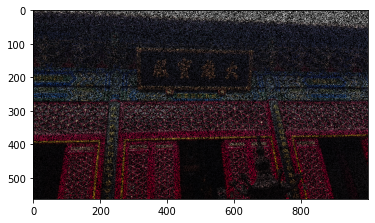

In [10]:
image, h, w, dims = image_read("/content/drive/MyDrive/Colab Notebooks/kSVD/Test_Fig2_Missing.png")

(563, 1001, 3)


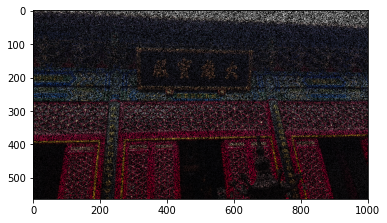

In [11]:
image = form_compatible_image(bb=8, overlap=3, image=image)

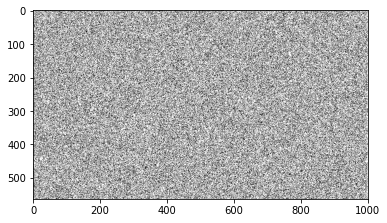

In [12]:
mask = get_mask(image)

In [13]:
patches = extract_image_patches(image=image, bb=8, overlap=3)

(563, 1001, 3)


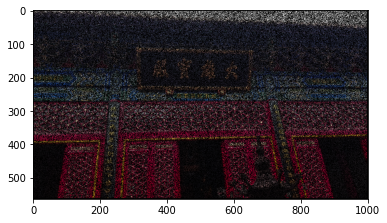

In [14]:
I = extract_image_from_patches(patches=patches, bb=8, overlap=3, image=image)

In [191]:
def OMP_Inpainting(D, X, Mask, sigma, rc_min, n_nonzero_coeff):
  """
  Orthogonal Matching pursuit
  ---------------------------
  Inputs:
    D - Dictionary
    X - The signals to represent
    errorGoal - Maximum allowed representation error

  Output:
    A - Sparse Coefficient Matrix

  """
  n, P = X.shape
  n, K = D.shape
  temp = np.zeros((K, P))
  for i in range(P):
    Mpos = np.argwhere(Mask[:, i]!=0)
    Mpos = Mpos.reshape(1, Mpos.shape[0])[0]
    Dict = D[Mpos, :]
    div = np.sqrt(np.diag(np.dot(Dict.T, Dict)))
    div[np.argwhere(div == 0)] = 0.000000001
    W=1.0/div;
    Dict=np.dot(Dict, np.diag(W));
    x=X[Mpos,i] # patch exclude mask
    x = x.reshape(x.shape[0], -1)
    a = []
    DD = []
    residual=x
    indx = []
    j = 0
    rc_max = 99999
    threshold = np.linalg.norm(x)*sigma
    while np.linalg.norm(residual)>threshold and rc_max>rc_min and len(a)<n_nonzero_coeff:
      
      proj= np.matmul(Dict.T,residual)
      pos = np.argmax(np.abs(proj), axis=0)
      indx.append(pos)
      if j==0:
        DD.append(Dict[:, pos])
        DDD = np.array(DD)
        DDD = DDD.reshape(DDD.shape[0]*DDD.shape[1], DDD.shape[2])
      else:
        DDD = np.concatenate((DDD, Dict[:, pos]), axis=1)
      a = np.matmul(scipy.linalg.pinv2(DDD),x)
      residual = x - np.matmul(DDD,a)
      j = j+1
    temp[indx, i] = a
    temp[:, i] = np.multiply(W, temp[:, i])
  return temp